# Caso de Estudio: Predicción del Precio del Oro con Redes LSTM
Este notebook implementa el análisis y modelo descrito en el markdown adjunto.

## 1. Business Case Discovery
### 1.1 Contexto del Negocio
La empresa Commodity Analytics busca optimizar estrategias de inversión en metales preciosos.

## 2. Data Processing


### Importing Required Libraries
This cell imports the necessary libraries for data analysis and downloads historical data for gold, DXY, bonds, and TIP from Yahoo Finance. It also processes the data to create derived features and technical indicators.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

# Descargar datos históricos desde Yahoo Finance
oro = yf.download("GC=F", start="2010-01-01")
dxy = yf.download("DX-Y.NYB", start="2010-01-01")
bonos = yf.download("^TNX", start="2010-01-01")
tip = yf.download("TIP", start="2010-01-01")

# Unión de datasets
df = pd.concat([oro['Close'], dxy['Close'], bonos['Close'], tip['Close']], axis=1).dropna()
df.columns = ['Oro', 'DXY', 'Bonos', 'TIP']

# Características derivadas
df['Ratio_Oro_DXY'] = df['Oro'] / df['DXY']
df['Inflacion_implicita'] = df['TIP'].pct_change()
df['Tasa_real'] = df['Bonos'] - df['Inflacion_implicita']

# Variables técnicas
df['SMA200'] = df['Oro'].rolling(window=200).mean()
df['Bollinger_up'] = df['Oro'].rolling(window=20).mean() + 2*df['Oro'].rolling(window=20).std()
df['Bollinger_down'] = df['Oro'].rolling(window=20).mean() - 2*df['Oro'].rolling(window=20).std()

df = df.dropna()
df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed



,Oro,DXY,Bonos,TIP,Ratio_Oro_DXY,Inflacion_implicita,Tasa_real,SMA200,Bollinger_up,Bollinger_down
Date,,,,,,,,,,
2010-10-19,1335.099976,78.180000,2.475,78.090248,17.077257,0.000537,2.474463,1189.230999,1388.590284,1265.079699
2010-10-20,1343.300049,77.169998,2.470,78.069283,17.407025,-0.000268,2.470269,1190.358999,1386.895931,1273.864054
2010-10-21,1324.699951,77.419998,2.531,78.069283,17.110566,0.000000,2.531000,1191.391999,1385.475709,1278.734277
2010-10-22,1324.400024,77.470001,2.563,78.090248,17.095650,0.000269,2.562731,1192.334499,1384.112541,1283.107442
2010-10-25,1338.300049,77.099998,2.554,78.327675,17.357978,0.003040,2.550959,1193.360499,1383.037908,1288.412080


### Temporal Window
This cell normalizes the data using a robust scaler and prepares it for time series prediction by creating a TimeseriesGenerator.

In [2]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import RobustScaler

# Normalización robusta de los datos
scaler = RobustScaler()
data_scaled = scaler.fit_transform(df)

# Ajustar los datos para el horizonte de predicción
look_back = 90  # 90 días de datos históricos
horizon = 5     # Predecir 5 días futuros

# Crear el generador de series temporales
generator = TimeseriesGenerator(
    data_scaled,  # Datos normalizados
    targets=data_scaled[:, 0],  # Predecir solo el precio del oro (columna 0)
    length=look_back,  # Ventana histórica
    sampling_rate=1,  # Usar cada día
    stride=1,  # Sin saltos
    batch_size=32,  # Tamaño del lote
    end_index=len(data_scaled) - horizon - 1,  # Evitar target leakage
    shuffle=True  # Mezclar las secuencias
)


#Ejemplo de secuencia resultante
X_sample, y_sample = generator[0]
print(f"Input shape: {X_sample.shape}")  # (batch, 90 días, 5 features)
print(f"Target shape: {y_sample.shape}") # (batch, 5 días a predecir)

Input shape: (32, 90, 10)
Target shape: (32,)


## 3. Model Planning
### 3.1 Definición del Problema

### Problem Definition
This cell defines the problem by preparing the data for training, validation, and testing. It splits the data into training, validation, and test sets.

In [3]:
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np

# — your data —
scaler = RobustScaler()
data_scaled = scaler.fit_transform(df)

look_back = 90
horizon   = 5

# you can still build X/Y manually…
X, Y = [], []
for i in range(len(data_scaled) - look_back - horizon):
    X.append(data_scaled[i : i + look_back])
    Y.append(data_scaled[i + look_back : i + look_back + horizon, 0])

X, Y = np.array(X), np.array(Y)
print(X.shape, Y.shape)

# …or use TimeseriesGenerator to do exactly that:
gen = TimeseriesGenerator(
    data_scaled,                  # full multivariate array
    data_scaled[:, 0],            # target series (gold price)
    length=look_back,
    sampling_rate=1,
    stride=1,
    start_index=0,
    end_index=None,
    shuffle=False,
    reverse=False,
    batch_size=32
)

(3554, 90, 10) (3554, 5)


### Model Architecture
This cell defines the architecture of the LSTM model, including layers for LSTM, dropout, and dense output.

In [4]:


split_train = int(len(X) * 0.7)
split_val = int(len(X) * 0.85)

X_train, Y_train = X[:split_train], Y[:split_train]
X_val, Y_val = X[split_train:split_val], Y[split_train:split_val]
X_test, Y_test = X[split_val:], Y[split_val:]



In [5]:


from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(192, return_sequences=True, input_shape=(look_back, X.shape[2])),
    Dropout(0.35),
    LSTM(96),
    Dense(horizon)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()



c:\Users\sergi\Desktop\MasterAI\GenAI_Dev\repo\ia-generativa-desarrollo\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 90, 192)        │       155,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 192)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 96)             │       110,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           485 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 267,365 (1.02 MB)

 Trainable params: 267,365 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

### Model Training
This cell trains the LSTM model using the training data and validates it using the validation data.

In [6]:


history = model.fit(X_train, Y_train, epochs=50, batch_size=32,
                    validation_data=(X_val, Y_val))



Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 19s 187ms/step - loss: 0.0348 - mae: 0.1240 - val_loss: 0.0258 - val_mae: 0.1247
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 19s 187ms/step - loss: 0.0348 - mae: 0.1240 - val_loss: 0.0258 - val_mae: 0.1247
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 188ms/step - loss: 0.0050 - mae: 0.0528 - val_loss: 0.0205 - val_mae: 0.1126
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 188ms/step - loss: 0.0050 - mae: 0.0528 - val_loss: 0.0205 - val_mae: 0.1126
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 189ms/step - loss: 0.0043 - mae: 0.0496 - val_loss: 0.0247 - val_mae: 0.1260
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 189ms/step - loss: 0.0043 - mae: 0.0496 - val_loss: 0.0247 - val_mae: 0.1260
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 186ms/step - loss: 0.0041 - mae: 0.0478 - val_loss: 0.0175 - val_mae: 0.1036
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 186ms/step - loss: 0.0041 - mae: 0.0478 - val_loss: 0.0175 - val_mae: 0.1036
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 185ms/

### Model Evaluation
This cell evaluates the model's performance by predicting the test data and visualizing the results.

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step


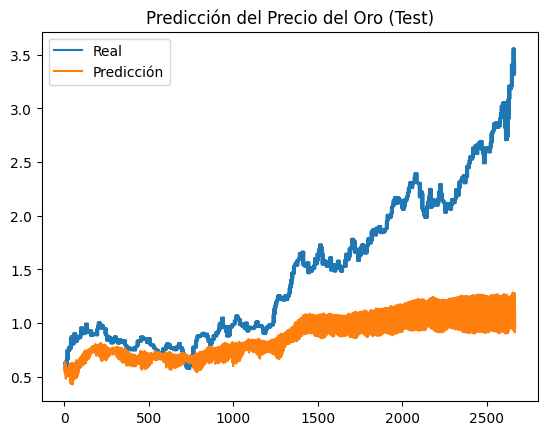

In [7]:


import matplotlib.pyplot as plt

preds = model.predict(X_test)
plt.plot(Y_test.flatten(), label='Real')
plt.plot(preds.flatten(), label='Predicción')
plt.legend()
plt.title('Predicción del Precio del Oro (Test)')
plt.show()



### Saving the Model
This cell saves the trained model and the scaler for future use.

In [8]:


model.save('modelo_oro_lstm.h5')
import joblib
joblib.dump(scaler, 'scaler_robust.pkl')



['scaler_robust.pkl']